# NMF for Colour Face Images

## Objectives :

* Understand the Concept of NMF and how it can be used to extract meanigful and necessary features from the objects of consideration, in our case it is **Colour Face Images**
* Exploring ways to implement NMF for **Colur Images**. My current approach is to **run NMF for every colour channel seperately** and then join their individual images to recontruct the image
* To check which approach is better, **Two Block Coordinate Descent** or **Deep NMF using Single / Multi-Layer network**
* Approach is checked by analysing the components and final image reconstruction



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Accessing Data

In [ ]:
from pathlib import Path

data_path = Path("/content/drive/MyDrive/Facial Data/Extracted Faces/Extracted Faces")
face_images_list = list(data_path.glob("*/*.jpg"))

len(face_images_list)

6107

### Choose Random 500 Images

In [ ]:
import random
import numpy as np

random_500_images_list = random.sample(face_images_list, 500)
len(random_500_images_list)

500

In [ ]:
random_500_images_list[:5]

[PosixPath('/content/drive/MyDrive/Facial Data/Extracted Faces/Extracted Faces/52/1.jpg'),
 PosixPath('/content/drive/MyDrive/Facial Data/Extracted Faces/Extracted Faces/1127/2.jpg'),
 PosixPath('/content/drive/MyDrive/Facial Data/Extracted Faces/Extracted Faces/900/5.jpg'),
 PosixPath('/content/drive/MyDrive/Facial Data/Extracted Faces/Extracted Faces/980/12.jpg'),
 PosixPath('/content/drive/MyDrive/Facial Data/Extracted Faces/Extracted Faces/1330/0.jpg')]

## Getting Sample Image metadata

In [ ]:
from PIL import Image

print(f"Total images : {len(random_500_images_list)}")

image = Image.open(random_500_images_list[0])
image_np = np.asarray(image)
print(f"Image dimension : {image_np.shape}")
print(f"Numpy representation : {image_np}")

Total images : 500
Image dimension : (128, 128, 3)
Numpy representation : [[[156 159 164]
  [137 140 145]
  [ 95  98 103]
  ...
  [ 81  69  47]
  [ 85  70  49]
  [ 86  71  50]]

 [[147 150 155]
  [126 129 134]
  [ 82  85  90]
  ...
  [ 81  69  47]
  [ 85  70  49]
  [ 87  72  51]]

 [[129 132 137]
  [110 113 118]
  [ 67  70  75]
  ...
  [ 83  68  47]
  [ 85  70  49]
  [ 86  71  50]]

 ...

 [[246 251 255]
  [247 252 255]
  [246 249 255]
  ...
  [238 242 251]
  [238 241 250]
  [237 240 249]]

 [[247 252 255]
  [246 251 255]
  [244 247 254]
  ...
  [240 243 252]
  [238 240 252]
  [237 239 251]]

 [[246 251 255]
  [244 249 253]
  [241 244 251]
  ...
  [241 244 253]
  [239 241 253]
  [237 239 251]]]


### Using PyTorch transforms to Resize the images

In [ ]:
from torchvision import transforms

resize_image = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()
])

transformed_img = resize_image(image)
print(f"Resized image size : {transformed_img.shape}")

Resized image size : torch.Size([3, 64, 64])


### Image Before and After the Transform

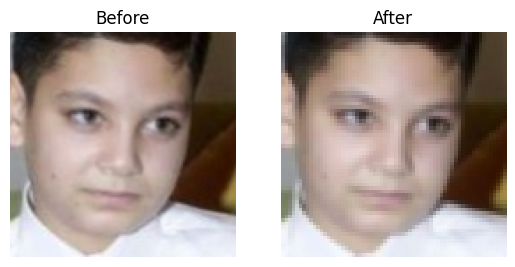

In [ ]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.title(f"Before")
plt.axis(False)
plt.imshow(image_np)

plt.subplot(1,2,2)
plt.title(f"After")
plt.axis(False)
plt.imshow(transformed_img.permute(1,2,0))
plt.show()

## Function to Create the X matrix

In [ ]:
from typing import List

def convert_to_X(data_path_list : List, transform) :

  red_images = []
  green_images = []
  blue_images = []

  for data_path in data_path_list:

    img = Image.open(data_path)
    transformed_img = resize_image(img).detach().numpy()

    red_part = transformed_img[0].flatten()
    green_part = transformed_img[1].flatten()
    blue_part = transformed_img[2].flatten()

    red_images.append(red_part)
    green_images.append(green_part)
    blue_images.append(blue_part)

  X_red = np.array(red_images).T
  X_green = np.array(green_images).T
  X_blue = np.array(blue_images).T

  return X_red, X_green, X_blue

X_red, X_green, X_blue = convert_to_X(random_500_images_list,resize_image)
print(f"X_red Shape : {X_red.shape}")
print(f"X_green Shape : {X_green.shape}")
print(f"X_blue Shape : {X_blue.shape}")

X_red Shape : (4096, 500)
X_green Shape : (4096, 500)
X_blue Shape : (4096, 500)


In [ ]:
X_green

array([[0.5254902 , 0.10980392, 0.09803922, ..., 0.45882353, 0.13333334,
        0.19607843],
       [0.26666668, 0.10980392, 0.11764706, ..., 0.4627451 , 0.13725491,
        0.3254902 ],
       [0.12156863, 0.1254902 , 0.14901961, ..., 0.46666667, 0.1254902 ,
        0.41960785],
       ...,
       [0.95686275, 0.01568628, 0.04705882, ..., 0.57254905, 0.1254902 ,
        0.16862746],
       [0.95686275, 0.02352941, 0.04705882, ..., 0.57254905, 0.1254902 ,
        0.15686275],
       [0.94509804, 0.03137255, 0.07450981, ..., 0.5803922 , 0.1254902 ,
        0.14117648]], dtype=float32)

## Class for NMF

In [ ]:
class NMF:

  def __init__(self, error_threshould : float, n_components : int) -> None:

    self.error_threshould = error_threshould
    self.n_components = n_components

    self.losses_red = []
    self.losses_green = []
    self.losses_blue = []

    self.W_red = None
    self.H_red = None
    self.W_green = None
    self.H_green = None
    self.W_blue = None
    self.H_blue = None

  def compute_loss(self,X,W,H) -> float:

    """
    Compute Loss for the current training step

    Arguments :
      X : Actual Data (p x n)
      W : r Basis Vector Matrix (p x r)
      H : New representation of the data (r x n)

    Returns :
      loss : Loss Calculated using frobenius norm of diff between Actual data and attempeted recontruction
    """

    loss = np.linalg.norm(X - np.dot(W,H))
    return loss

  def train_red_component(self, X_red) -> None:

    """
    Train step for calculating the basis vectors for Red component of the image

    Arguments :
      X_red : Actual Data of the Red component of Image

    Returns :
      None
    """

    W_red = np.random.rand(X_red.shape[0], self.n_components)
    H_red = np.random.rand(self.n_components, X_red.shape[1])

    loss = self.compute_loss(X = X_red, W = W_red, H = H_red)

    while(loss>self.error_threshould):

      H_red = H_red*(np.dot(W_red.T, X_red) / np.dot(np.dot(W_red.T, W_red),H_red))
      W_red = W_red*(np.dot(X_red, H_red.T) / np.dot(np.dot(W_red, H_red), H_red.T))

      loss = self.compute_loss(X_red, W_red, H_red)
      self.losses_red.append(loss)

    self.W_red = W_red
    self.H_red = H_red

  def train_green_component(self, X_green) -> None:

    """
    Train step for calculating the basis vectors for Green component of the image

    Arguments :
      X_green : Actual Data of the Green component of Image

    Returns :
      None
    """

    W_green = np.random.rand(X_green.shape[0], self.n_components)
    H_green = np.random.rand(self.n_components, X_green.shape[1])

    loss = self.compute_loss(X = X_green, W = W_green, H = H_green)

    while(loss>self.error_threshould):

      H_green = H_green*(np.dot(W_green.T, X_green) / np.dot(np.dot(W_green.T, W_green),H_green))
      W_green = W_green*(np.dot(X_green, H_green.T) / np.dot(np.dot(W_green, H_green), H_green.T))

      loss = self.compute_loss(X_green, W_green, H_green)
      self.losses_green.append(loss)

    self.W_green = W_green
    self.H_green = H_green

  def train_blue_component(self, X_blue) -> None:

    """
    Train step for calculating the basis vectors for Blue component of the image

    Arguments :
      X_blue : Actual Data of the Blue component of Image

    Returns :
      None
    """

    W_blue = np.random.rand(X_blue.shape[0], self.n_components)
    H_blue = np.random.rand(self.n_components, X_blue.shape[1])

    loss = self.compute_loss(X = X_blue, W = W_blue, H = H_blue)

    while(loss>self.error_threshould):

      H_blue = H_blue*(np.dot(W_blue.T, X_blue) / np.dot(np.dot(W_blue.T, W_blue),H_blue))
      W_blue = W_blue*(np.dot(X_blue, H_blue.T) / np.dot(np.dot(W_blue, H_blue), H_blue.T))

      loss = self.compute_loss(X_blue, W_blue, H_blue)
      self.losses_blue.append(loss)

    self.W_blue = W_blue
    self.H_blue = H_blue

  def fit(self, X_red, X_green, X_blue) -> None:

    """
    Fit the Image data to the model

    Arguments :
      X_red : Actual Data of the red component of the image
      X_green : Actual Data of the green component of the image
      X_blue : Actual Data of the blue component of the image

    Returns:
      None
    """

    print("Training Red Component ...")
    self.train_red_component(X_red = X_red)

    print("Training Green Component ...")
    self.train_green_component(X_green = X_green)

    print("Training Blue Component ...")
    self.train_blue_component(X_blue = X_blue)

    print("Training Complete !!!")

  def get_losses(self):

    """
    Getter for all the losses calculated during the training

    Returns:
      losses_red : Array of all the losses calculated during training Red component
      losses_green : Array of all the losses calculated during training Green component
      losses_blue : Array of all the losses calculated during training Blue component
    """

    return self.losses_red, self.losses_green, self.losses_blue

  def get_red_matrices(self):

    """
    Getter function for Red component of the image

    Returns:
      W_red : Learned Vector Basis for the Red component
      H_red : New Representation of the Red component
    """

    return self.W_red, self.H_red


  def get_green_matrices(self):

    """
    Getter function for Green component of the image

    Returns:
      W_green : Learned Vector Basis for the Green component
      H_green : New Representation of the Green component
    """

    return self.W_green, self.H_green

  def get_blue_matrices(self):

    """
    Getter function for Blue component of the image

    Returns:
      W_blue : Learned Vector Basis for the Blue component
      H_blue : New Representation of the Blue component
    """

    return self.W_blue, self.H_blue

  def get_components(self):

    """
    Getter function for all the componenets of the image

    Returns :
      W_red : Learned Vector Basis for the Red component
      W_green : Learned Vector Basis for the Green component
      W_blue : Learned Vector Basis for the Blue component
    """

    return self.W_red, self.W_green, self.W_blue

  def get_transforms(self):

    """
    Getter for the new transforms of the Image RGB components

    Returns :
      H_red : New Representation of the Red component
      H_green : New Representation of the Green component
      H_blue : New Representation of the Blue component
    """

    return self.H_red, self.H_green, self.H_blue

  def get_inverse_transform(self):
    """
    Getter for the new inverse transforms using the learned components and representation

    Returns :
      X_red = np.dot(W_red,H_red)
      X_green = np.dot(W_green,H_green)
      X_blue = np.dot(W_blue,H_blue)
    """

    X_red_reconstructed = np.dot(self.W_red, self.H_red)
    X_green_reconstructed = np.dot(self.W_green, self.H_green)
    X_blue_reconstructed = np.dot(self.W_blue, self.H_blue)

    return X_red_reconstructed, X_green_reconstructed, X_blue_reconstructed


In [ ]:
ERROR_THRESHOULD = 85
N_COMPONENTS = 128

nmf_model_0 = NMF(error_threshould=ERROR_THRESHOULD, n_components=N_COMPONENTS)
nmf_model_0.fit(X_red, X_green, X_blue)

Training Red Component ...
Training Green Component ...
Training Blue Component ...
Training Complete !!!


In [ ]:
losses_red, losses_green, losses_blue = nmf_model_0.get_losses()

In [ ]:
print(f"Final Red loss : {min(losses_red)}")
print(f"Final Green loss : {min(losses_green)}")
print(f"Final Blue loss : {min(losses_blue)}")

Final Red loss : 84.99460683467915
Final Green loss : 84.9831376024659
Final Blue loss : 84.97204009178957


### Plot Loss for RGB Components

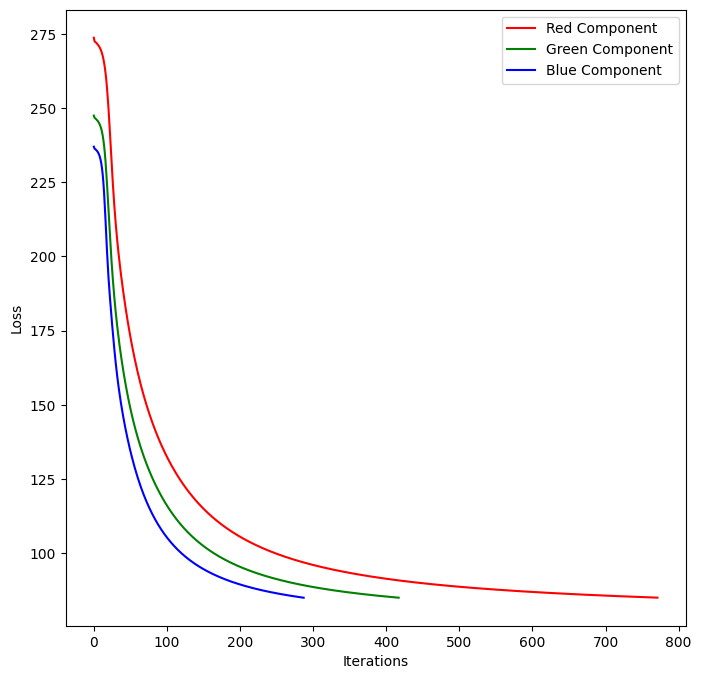

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))

plt.plot(range(len(losses_red)),losses_red, label = "Red Component", c='r')
plt.plot(range(len(losses_green)),losses_green, label = "Green Component", c='g')
plt.plot(range(len(losses_blue)),losses_blue, label = "Blue Component", c='b')

plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.legend()

plt.show()

## Analysing Components

In [ ]:
W_red, W_green, W_blue = nmf_model_0.get_components()
W_red.shape, W_green.shape, W_blue.shape

((4096, 128), (4096, 128), (4096, 128))

In [ ]:
W_red.min(), W_red.max()

(6.936019493709643e-27, 31.307912712059043)

In [ ]:
W_green.min(), W_green.max()

(1.6399124902739798e-24, 31.777603488944877)

In [ ]:
W_blue.min(), W_blue.max()

(2.6130527200433184e-15, 27.516813876623747)

### Red Component

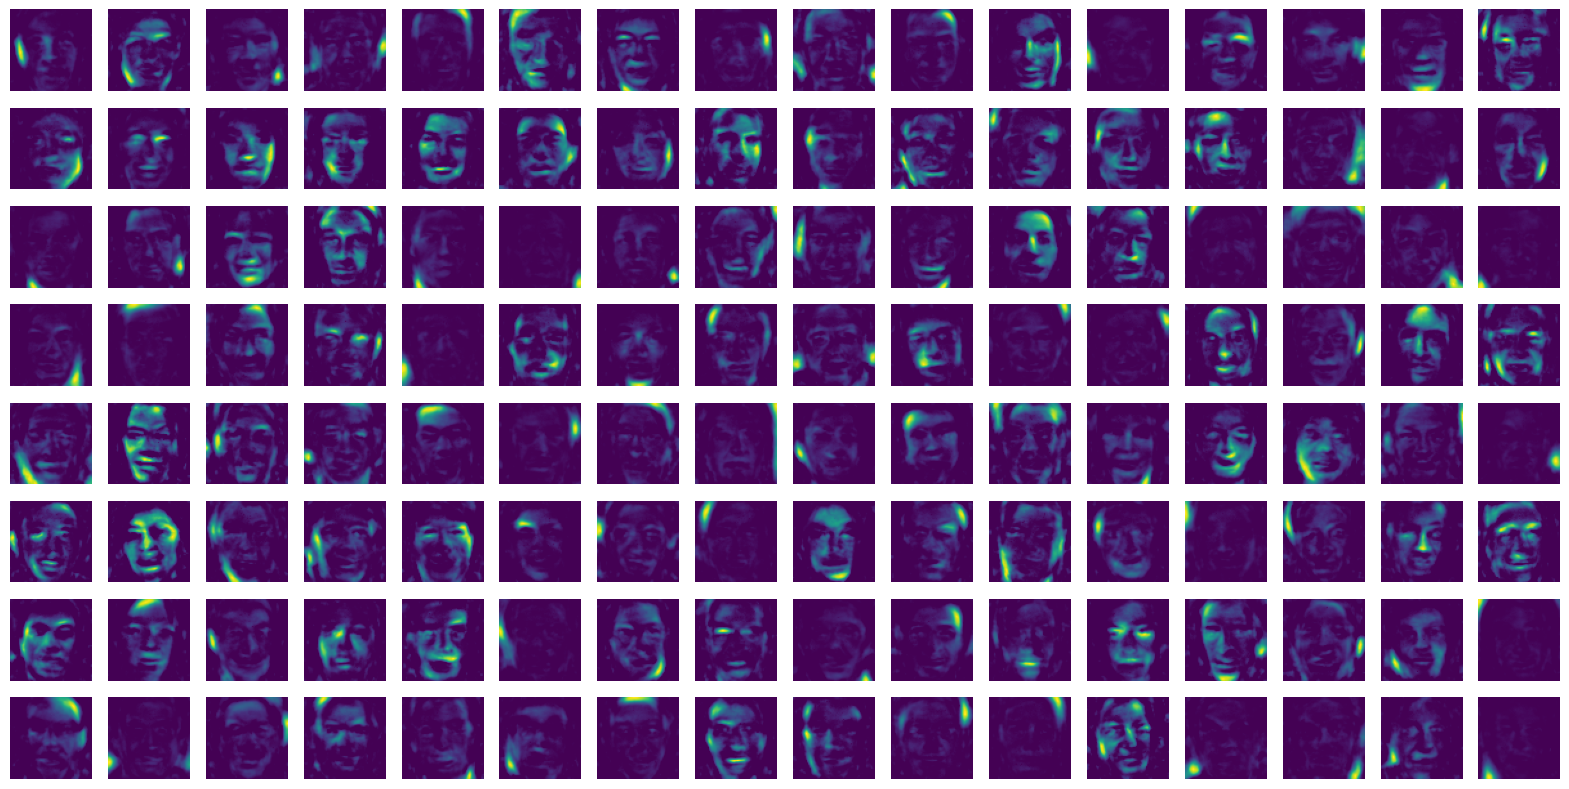

In [ ]:
fig = plt.figure(figsize = (20,10))

for i in range(128):
  plt.subplot(8,16,i+1)
  plt.imshow(W_red.T[i].reshape(64,64))
  plt.set_cmap("viridis")
  plt.axis(False)

### Green Component

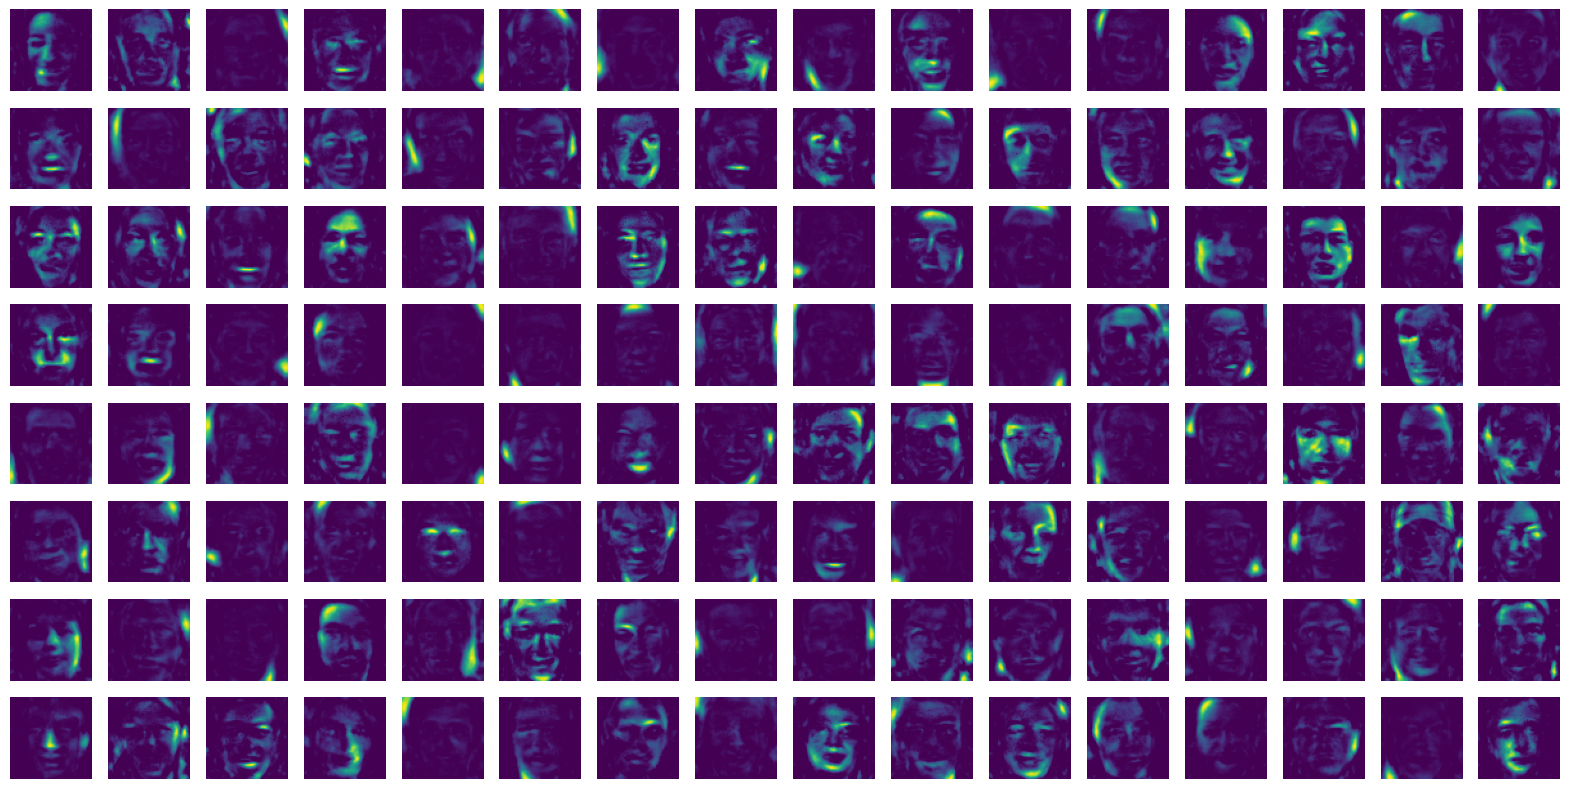

In [ ]:
fig = plt.figure(figsize = (20,10))

for i in range(128):
  plt.subplot(8,16,i+1)
  plt.imshow(W_green.T[i].reshape(64,64))
  plt.set_cmap("viridis")
  plt.axis(False)

### Blue Component

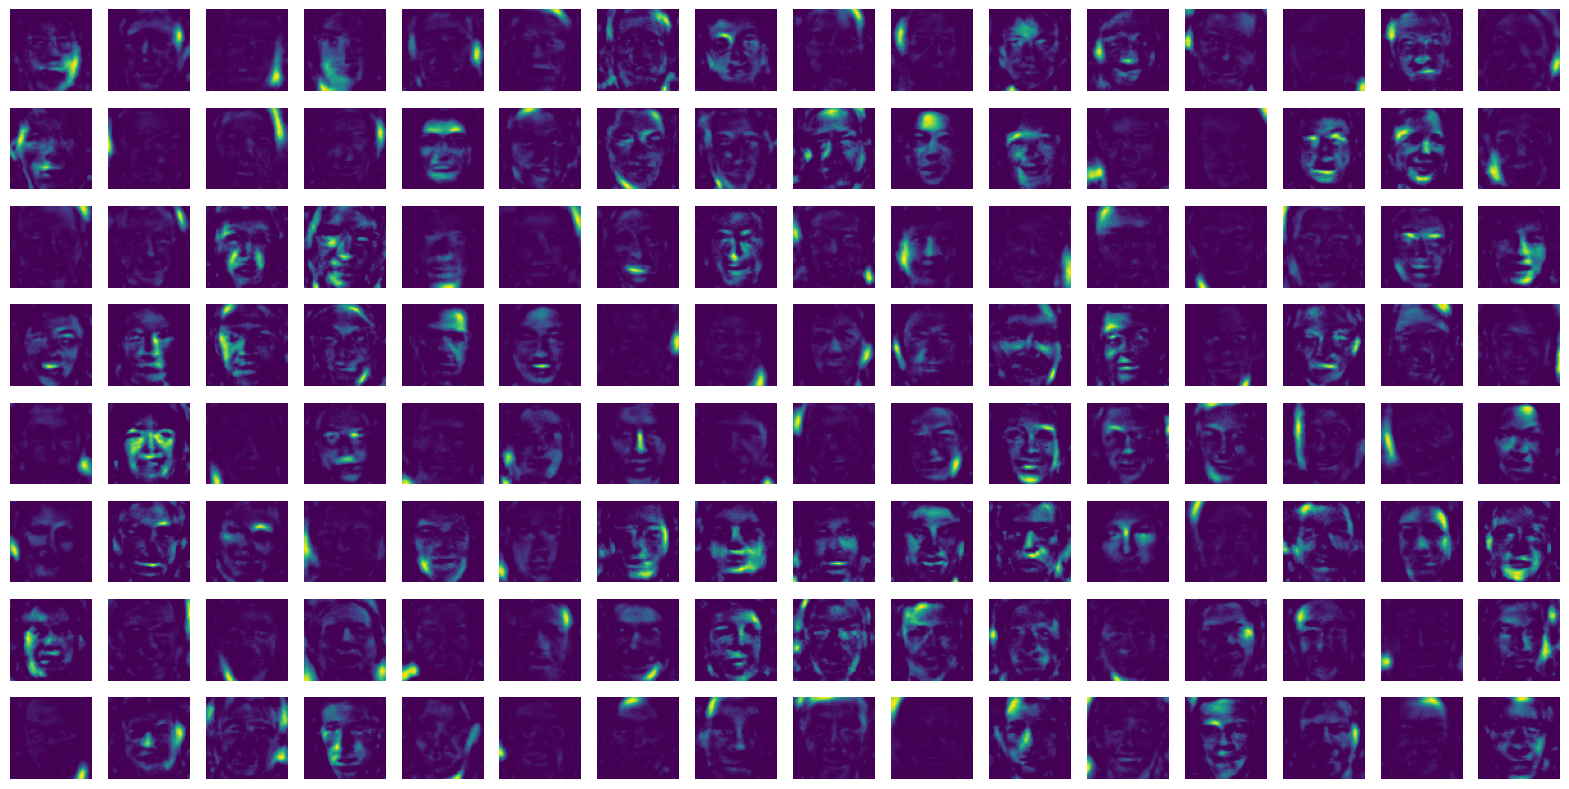

In [ ]:
fig = plt.figure(figsize = (20,10))

for i in range(128):
  plt.subplot(8,16,i+1)
  plt.imshow(W_blue.T[i].reshape(64,64))
  plt.set_cmap("viridis")
  plt.axis(False)

## Image Reconstruction

In [ ]:
X_red_reconstructed, X_green_reconstructed, X_blue_reconstructed = nmf_model_0.get_inverse_transform()
X_red_reconstructed.shape, X_green_reconstructed.shape, X_blue_reconstructed.shape

((4096, 500), (4096, 500), (4096, 500))

### Comparing 5 Images

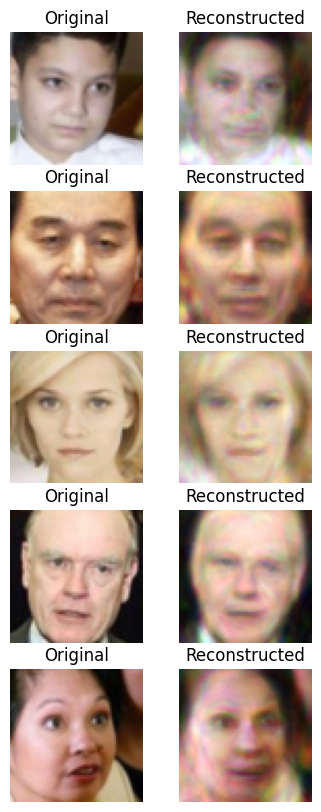

In [ ]:
fig = plt.figure(figsize=(4,10))

for i in range(0,10,2):

  original_image = Image.open(random_500_images_list[i])
  transformed_img = resize_image(original_image).permute(1,2,0)

  plt.subplot(5,2,i+1)
  plt.title("Original")
  plt.axis(False)
  plt.imshow(transformed_img)

  sample_img = np.dstack((X_red_reconstructed.T[i].reshape(64,64), X_green_reconstructed.T[i].reshape(64,64), X_blue_reconstructed.T[i].reshape(64,64)))

  for row in range(64):
    for col in range(64):
      for color in range(3):

        if(sample_img[row][col][color]>1.0):
          sample_img[row][col][color] = 1.0

  plt.subplot(5,2,i+2)
  plt.title("Reconstructed")
  plt.axis(False)
  plt.imshow(sample_img)

# Deep NMF for Colour Images

In [ ]:
import torch
from torch import nn

## Neural Network Class Single Layer

In [ ]:
class NMF_nn_single(nn.Module):

  def __init__(self) -> None:
    super().__init__()

    self.layers = nn.Linear(in_features=64*64, out_features=128)
    self.W_1 = None

  def forward(self, X : torch.Tensor()) -> torch.Tensor:

    H = self.layers(X)
    self.W_1 = self.layers.weight
    X_recontructed = H@self.W_1

    return X_recontructed

In [ ]:
X_red_tensor = torch.tensor(X_red.T, dtype=torch.float32)
X_green_tensor = torch.tensor(X_green.T, dtype=torch.float32)
X_blue_tensor = torch.tensor(X_blue.T, dtype=torch.float32)

In [ ]:
X_red_tensor.shape

torch.Size([500, 4096])

In [ ]:
X_red_tensor

tensor([[0.5137, 0.2549, 0.1059,  ..., 0.9412, 0.9451, 0.9333],
        [0.2314, 0.2196, 0.2235,  ..., 0.0431, 0.0471, 0.0510],
        [0.1176, 0.1529, 0.2078,  ..., 0.0824, 0.0980, 0.1529],
        ...,
        [0.5373, 0.5412, 0.5569,  ..., 0.5961, 0.6039, 0.6118],
        [0.1686, 0.1725, 0.1686,  ..., 0.2078, 0.2039, 0.2078],
        [0.1529, 0.2941, 0.4000,  ..., 0.1059, 0.1020, 0.1059]])

In [ ]:
nmf_nn_red_model = NMF_nn_single()
nmf_nn_green_model = NMF_nn_single()
nmf_nn_blue_model = NMF_nn_single()

### Sanity Check

In [ ]:
try :
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

In [ ]:
from torchinfo import summary

nmf_nn_red_model.eval()
with torch.inference_mode():

  X_red_reconstructed = nmf_nn_red_model(X_red_tensor)

print(f"X_reconstructed shape : {X_red_reconstructed.shape}")

X_reconstructed shape : torch.Size([500, 4096])


In [ ]:
summary(nmf_nn_red_model, input_size=X_red_tensor.shape)

Layer (type:depth-idx)                   Output Shape              Param #
NMF_nn_single                            [500, 4096]               --
├─Linear: 1-1                            [500, 128]                524,416
Total params: 524,416
Trainable params: 524,416
Non-trainable params: 0
Total mult-adds (M): 262.21
Input size (MB): 8.19
Forward/backward pass size (MB): 0.51
Params size (MB): 2.10
Estimated Total Size (MB): 10.80

## Loss Function

In [ ]:
def frobenius_norm_loss(target, output):

  return torch.sqrt(torch.sum((target-output)**2))

loss_fn = frobenius_norm_loss

## Optimiser Single Layer

In [ ]:
optimiser_red = torch.optim.Adam(nmf_nn_red_model.parameters(), lr=0.001)
optimiser_green = torch.optim.Adam(nmf_nn_green_model.parameters(), lr=0.001)
optimiser_blue = torch.optim.Adam(nmf_nn_blue_model.parameters(), lr=0.001)

## Training Data (Single Layer)

In [ ]:
from tqdm.auto import tqdm

EPOCHS = 2000

red_losses = []
green_losses = []
blue_losses = []

for epoch in tqdm(range(EPOCHS)):

  X_red_reconstructed = nmf_nn_red_model(X_red_tensor)

  red_loss = loss_fn(X_red_tensor, X_red_reconstructed)
  red_losses.append(red_loss.detach().numpy())

  optimiser_red.zero_grad()

  red_loss.backward()

  optimiser_red.step()

  for val in nmf_nn_red_model.parameters():
    val.data.clamp_(0)


for epoch in tqdm(range(EPOCHS)):

  X_green_reconstructed = nmf_nn_green_model(X_green_tensor)

  green_loss = loss_fn(X_green_tensor, X_green_reconstructed)
  green_losses.append(green_loss.detach().numpy())

  optimiser_green.zero_grad()

  green_loss.backward()

  optimiser_green.step()

  for val in nmf_nn_green_model.parameters():
    val.data.clamp_(0)

for epoch in tqdm(range(EPOCHS)):

  X_blue_reconstructed = nmf_nn_blue_model(X_blue_tensor)

  blue_loss = loss_fn(X_blue_tensor, X_blue_reconstructed)
  blue_losses.append(blue_loss.detach().numpy())

  optimiser_blue.zero_grad()

  blue_loss.backward()

  optimiser_blue.step()

  for val in nmf_nn_blue_model.parameters():
    val.data.clamp_(0)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

## Loss Plot Function

In [ ]:
import matplotlib.pyplot as plt

def loss_plot(red_losses : List, green_losses : List, blue_losses : List):

  fig = plt.figure(figsize=(8,8))

  plt.plot(range(len(red_losses)),red_losses, label = "Red Component", c='r')
  plt.plot(range(len(green_losses)),green_losses, label = "Green Component", c='g')
  plt.plot(range(len(blue_losses)),blue_losses, label = "Blue Component", c='b')

  plt.ylabel("Loss")
  plt.xlabel("Iterations")
  plt.legend()

  plt.show()

## Loss Plot Single Layer

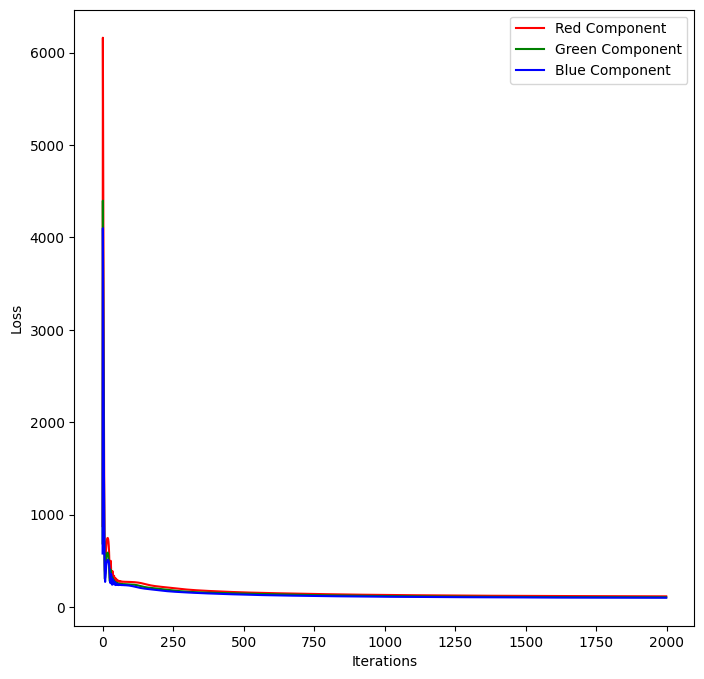

In [ ]:
loss_plot(red_losses=red_losses, green_losses=green_losses, blue_losses=blue_losses)

## Analysing Components Single Layer

### Red Component

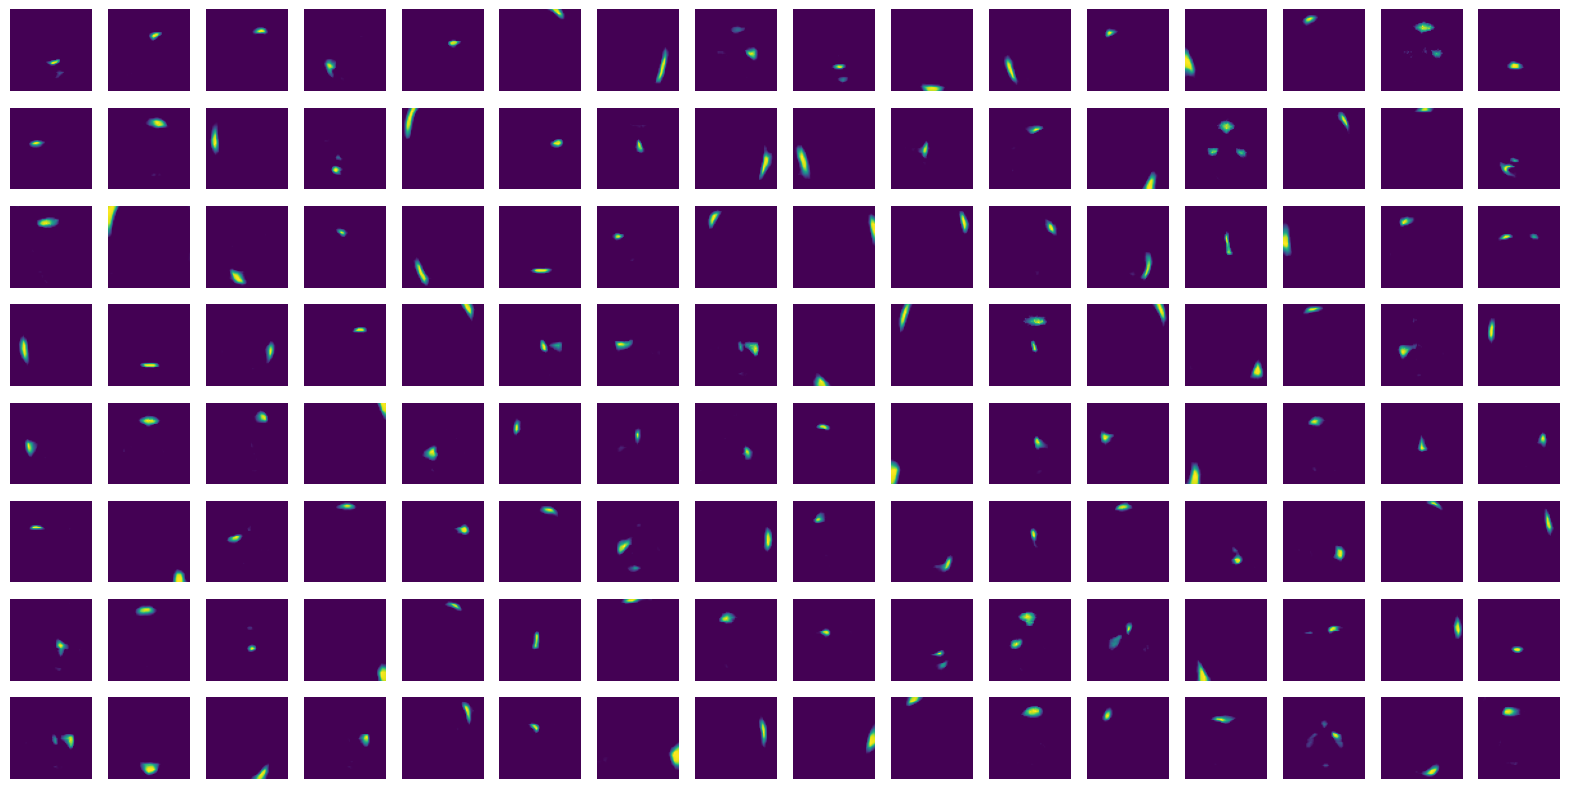

In [ ]:
fig = plt.figure(figsize = (20,10))

for i in range(128):
  plt.subplot(8,16,i+1)
  plt.imshow(nmf_nn_red_model.W_1.detach().numpy()[i].reshape(64,64))
  plt.set_cmap("viridis")
  plt.axis(False)

### Green Component

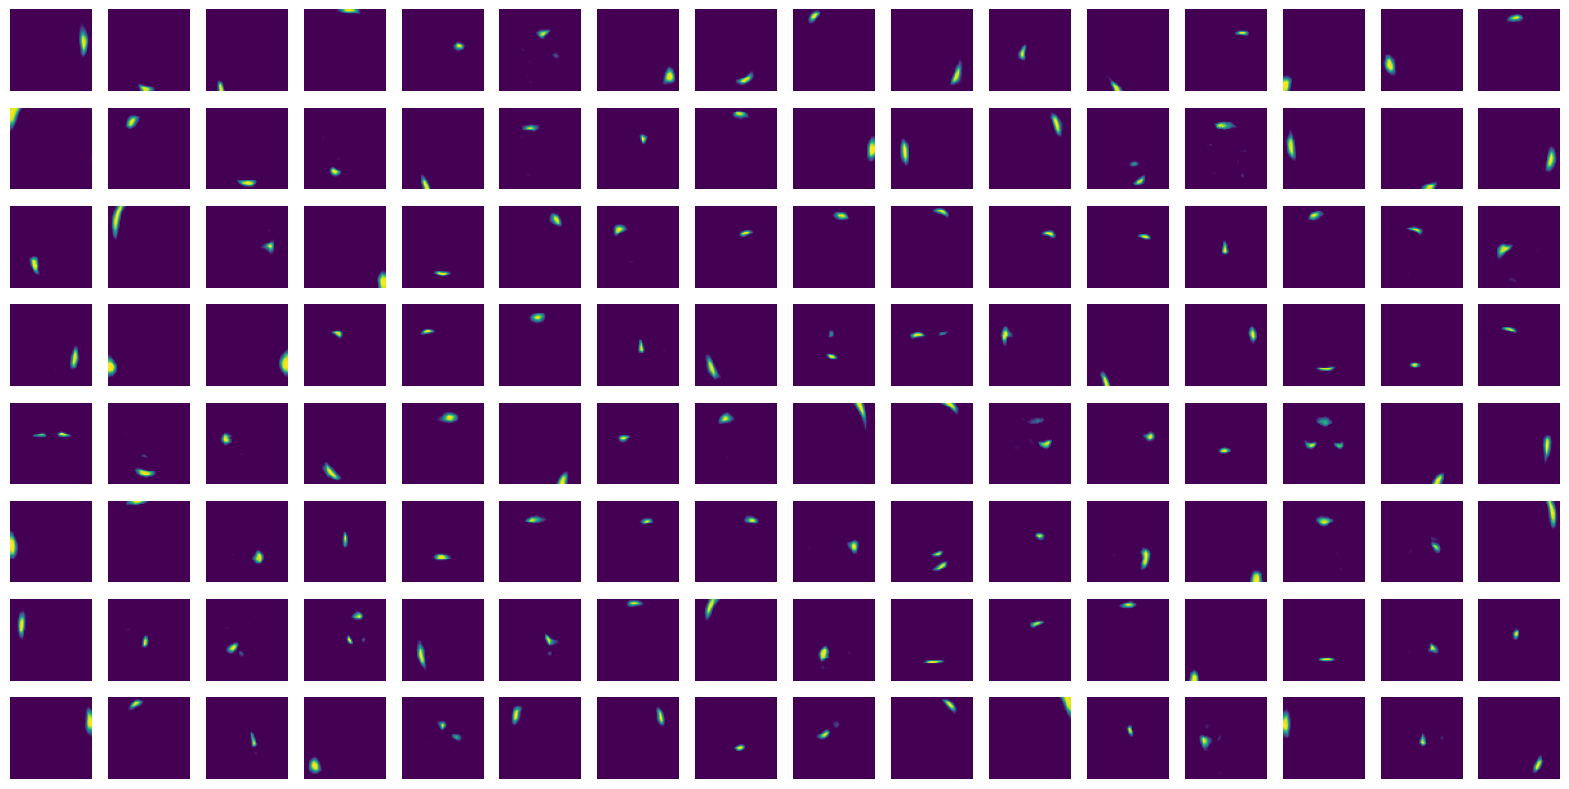

In [ ]:
fig = plt.figure(figsize = (20,10))

for i in range(128):
  plt.subplot(8,16,i+1)
  plt.imshow(nmf_nn_green_model.W_1.detach().numpy()[i].reshape(64,64))
  plt.set_cmap("viridis")
  plt.axis(False)

### Blue Component

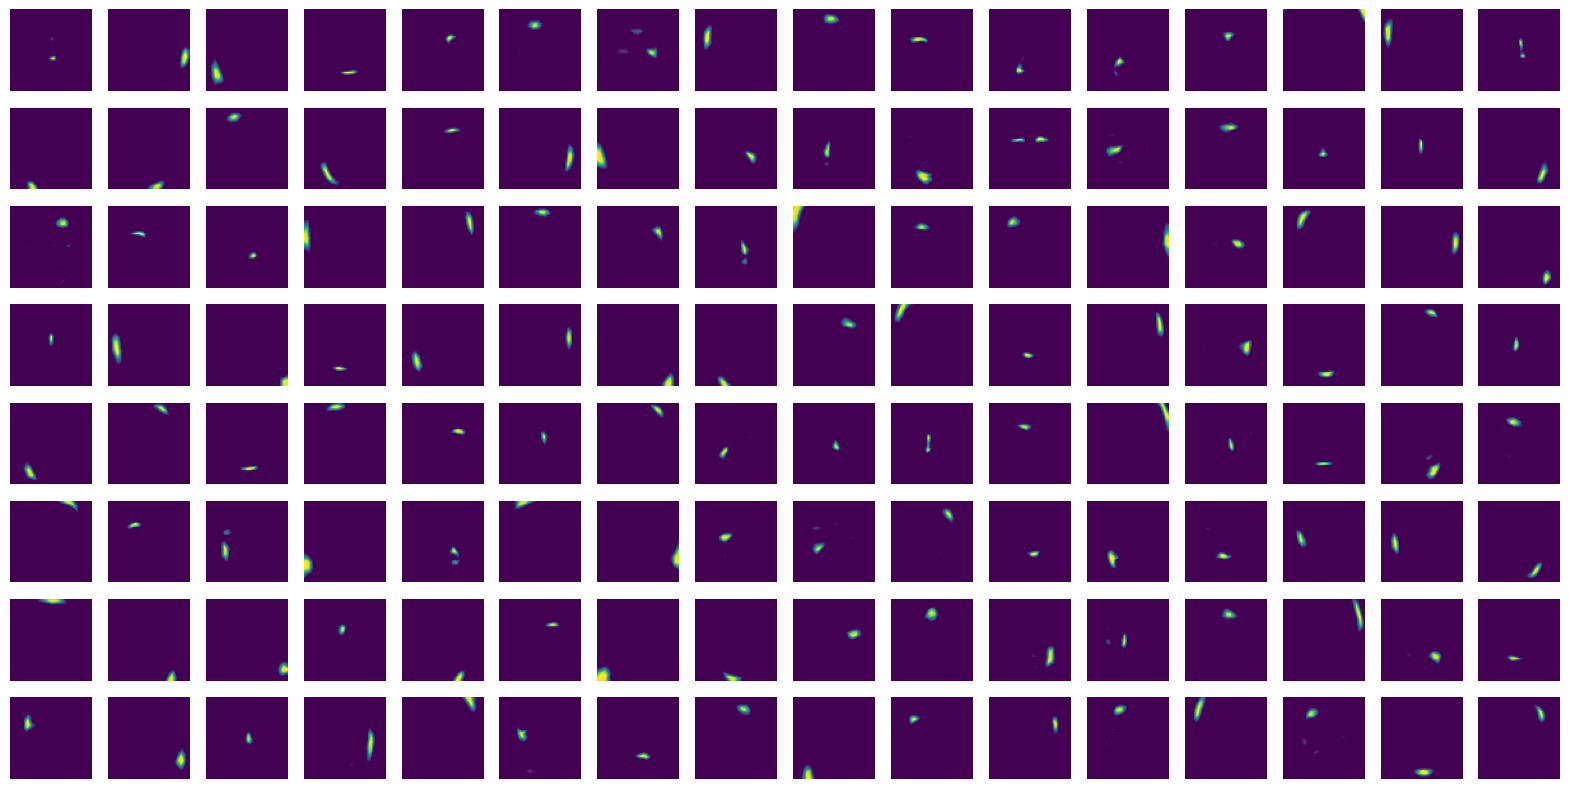

In [ ]:
fig = plt.figure(figsize = (20,10))

for i in range(128):
  plt.subplot(8,16,i+1)
  plt.imshow(nmf_nn_blue_model.W_1.detach().numpy()[i].reshape(64,64))
  plt.set_cmap("viridis")
  plt.axis(False)

## Image Recontruction Function

In [ ]:
def image_reconstruction(model_red : nn.Module, model_green : nn.Module, model_blue : nn.Module, image_list : List):

  fig = plt.figure(figsize=(4,10))

  for i in range(0,10,2):

    original_image = Image.open(image_list[i])
    transformed_img = resize_image(original_image).permute(1,2,0)

    plt.subplot(5,2,i+1)
    plt.title("Original")
    plt.axis(False)
    plt.imshow(transformed_img)

    sample_img = np.dstack((model_red(X_red_tensor).detach().numpy()[i].reshape(64,64),
                            model_green(X_green_tensor).detach().numpy()[i].reshape(64,64),
                            model_blue(X_blue_tensor).detach().numpy()[i].reshape(64,64)))

    for row in range(64):
      for col in range(64):
        for color in range(3):

          if(sample_img[row][col][color]>1.0):
            sample_img[row][col][color] = 1.0
          if(sample_img[row][col][color]<0.0):
            sample_img[row][col][color] = 0.0

    plt.subplot(5,2,i+2)
    plt.title("Reconstructed")
    plt.axis(False)
    plt.imshow(sample_img)

## Image Reconstruction for Single Layer NN

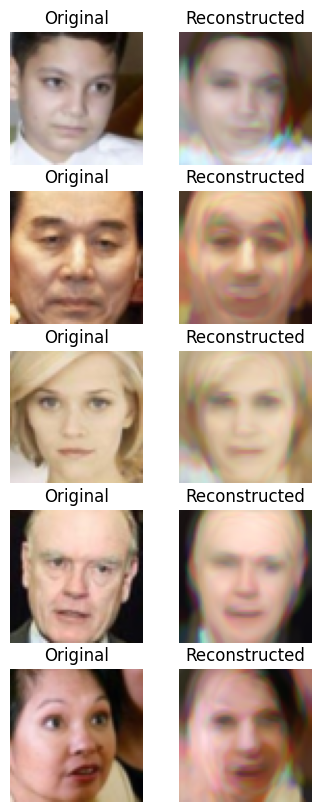

In [ ]:
image_reconstruction(nmf_nn_red_model, nmf_nn_green_model, nmf_nn_blue_model, random_500_images_list)

## Neural Network Class Multi-Layer

In [ ]:
class NMF_nn(nn.Module):

  def __init__(self) -> None:
    super().__init__()

    self.layers = nn.Sequential(
        nn.Linear(in_features=64*64, out_features=32*32),
        nn.Linear(in_features=32*32, out_features=16*16),
        nn.Linear(in_features=16*16, out_features=128),
    )

  def forward(self, X : torch.Tensor()) -> torch.Tensor:

    H = self.layers(X)
    model_dict = self.layers.state_dict()
    A_1 = model_dict['0.weight']
    A_2 = model_dict['1.weight']
    A_3 = model_dict['2.weight']
    X_recontructed = H@A_3@A_2@A_1

    return X_recontructed

In [ ]:
nmf_nn_red_model_1 = NMF_nn()
nmf_nn_green_model_1 = NMF_nn()
nmf_nn_blue_model_1 = NMF_nn()

### Sanity Check

In [ ]:
from torchinfo import summary

nmf_nn_red_model.eval()
with torch.inference_mode():

  X_red_reconstructed = nmf_nn_red_model_1(X_red_tensor)

print(f"X_reconstructed shape : {X_red_reconstructed.shape}")

X_reconstructed shape : torch.Size([500, 4096])


In [ ]:
summary(nmf_nn_red_model_1, input_size=X_red_tensor.shape)

Layer (type:depth-idx)                   Output Shape              Param #
NMF_nn                                   [500, 4096]               --
├─Sequential: 1-1                        [500, 128]                --
│    └─Linear: 2-1                       [500, 1024]               4,195,328
│    └─Linear: 2-2                       [500, 256]                262,400
│    └─Linear: 2-3                       [500, 128]                32,896
Total params: 4,490,624
Trainable params: 4,490,624
Non-trainable params: 0
Total mult-adds (G): 2.25
Input size (MB): 8.19
Forward/backward pass size (MB): 5.63
Params size (MB): 17.96
Estimated Total Size (MB): 31.79

## Optimiser Multi-Layer

In [ ]:
optimiser_red_1 = torch.optim.Adam(nmf_nn_red_model_1.parameters(), lr=0.001)
optimiser_green_1 = torch.optim.Adam(nmf_nn_green_model_1.parameters(), lr=0.001)
optimiser_blue_1 = torch.optim.Adam(nmf_nn_blue_model_1.parameters(), lr=0.001)

## Training Data (Multi - Layer)

In [ ]:
from tqdm.auto import tqdm

EPOCHS = 500

red_losses = []
green_losses = []
blue_losses = []

for epoch in tqdm(range(EPOCHS)):

  X_red_reconstructed = nmf_nn_red_model_1(X_red_tensor)

  red_loss = loss_fn(X_red_tensor, X_red_reconstructed)
  red_losses.append(red_loss.detach().numpy())

  optimiser_red_1.zero_grad()

  red_loss.backward()

  optimiser_red_1.step()

  for val in nmf_nn_red_model_1.parameters():
    val.data.clamp_(0)


for epoch in tqdm(range(EPOCHS)):

  X_green_reconstructed = nmf_nn_green_model_1(X_green_tensor)

  green_loss = loss_fn(X_green_tensor, X_green_reconstructed)
  green_losses.append(green_loss.detach().numpy())

  optimiser_green_1.zero_grad()

  green_loss.backward()

  optimiser_green_1.step()

  for val in nmf_nn_green_model_1.parameters():
    val.data.clamp_(0)

for epoch in tqdm(range(EPOCHS)):

  X_blue_reconstructed = nmf_nn_blue_model_1(X_blue_tensor)

  blue_loss = loss_fn(X_blue_tensor, X_blue_reconstructed)
  blue_losses.append(blue_loss.detach().numpy())

  optimiser_blue_1.zero_grad()

  blue_loss.backward()

  optimiser_blue_1.step()

  for val in nmf_nn_blue_model_1.parameters():
    val.data.clamp_(0)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

## Loss Plot Multi-Layer

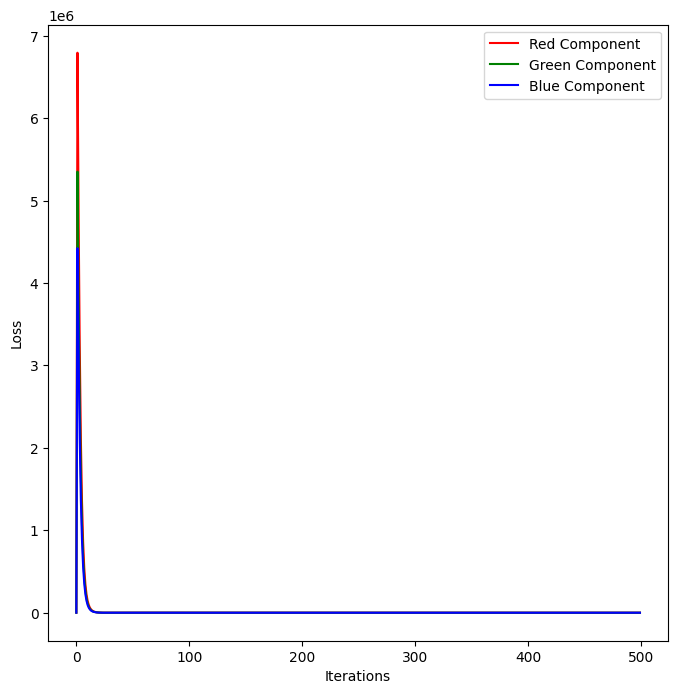

In [ ]:
loss_plot(red_losses=red_losses, green_losses=green_losses, blue_losses=blue_losses)

## Image Reconstruction for Multi - Layer NN

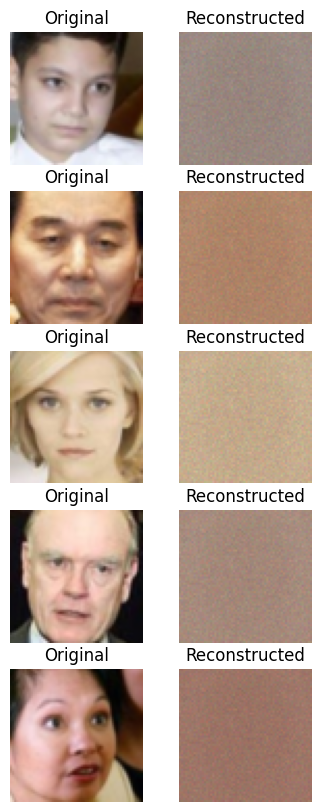

In [ ]:
image_reconstruction(nmf_nn_red_model_1, nmf_nn_green_model_1, nmf_nn_blue_model_1, random_500_images_list)

## References :


* [The Why and How of Nonnegative Matrix Factorization, Nicolas Gillis](https://arxiv.org/pdf/1401.5226.pdf)
* [Deep NMF Topic Modeling
Jian-Yu Wang and Xiao-Lei Zhang](https://arxiv.org/pdf/2102.12998.pdf)
* [Labeled Faces in the Wild (LFW) Face Dataset](http://vis-www.cs.umass.edu/lfw/)
* Jignesh Sir Notes (Error Threshould Idea)

